## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")
%matplotlib inline

# Predict time series with recurrent neural network

## Loading data

In [2]:
co2 = pd.read_table('./ml_flask_week.dat', header=None, sep=' ', names=['Dates', 'Vals'])
co2.head()

,Dates,Vals
0,1992/5/8,360.123333
1,1992/5/15,358.606667
2,1992/5/22,359.181667
3,1992/5/29,360.756667
4,1992/6/5,360.643333


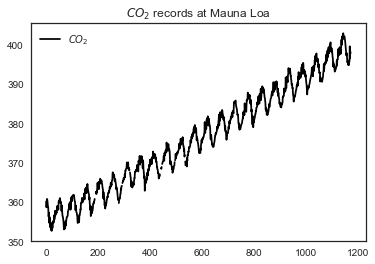

In [3]:
plt.plot(co2['Vals'], '-k', label='$CO_2$')
plt.title('$CO_2$ records at Mauna Loa')
plt.legend(loc='best')

In [4]:
thr = pd.read_table('./down_up_lims.txt', header=None, sep=' ', names=['Min', 'Max'])
thr.head()

,Min,Max
0,-0.063370,0.042293
1,-0.062572,0.040197
2,-0.066735,0.039887
3,-0.066333,0.045417
4,-0.063121,0.053316


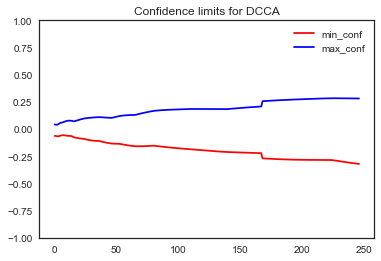

In [5]:
plt.plot(thr['Min'], '-r', label='min_conf')
plt.plot(thr['Max'], '-b', label='max_conf')
plt.ylim(-1, 1)
plt.title('Confidence limits for DCCA')
plt.legend(loc='best')

## ML imports

In [6]:
#from sklearn.preprocessing import StandardScaler

import tensorflow as tf

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Train and test sets

In [7]:
minX = thr['Min']
maxX = thr['Max']
split_thr = 220
min_train = np.array(minX[:split_thr])
max_train = np.array(maxX[:split_thr])
min_test = np.array(minX[split_thr:])
max_test = np.array(maxX[split_thr:])
print('min_train shape: {}'.format(min_train.shape))
print('max_train shape: {}'.format(max_train.shape))
print('min_test shape: {}'.format(min_test.shape))
print('max_test shape: {}'.format(max_test.shape))

min_train shape: (220,)
max_train shape: (220,)
min_test shape: (27,)
max_test shape: (27,)


## Setting graph

In [8]:
# parameters
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

In [18]:
# placeholders
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
#cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
#                                              output_size=n_outputs)
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.LSTMCell(num_units=n_neurons, activation=tf.nn.relu),
                                              output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

ValueError: Variable rnn/output_projection_wrapper/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell.py", line 99, in __init__
    initializer=kernel_initializer)
  File "/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell.py", line 380, in call
    self._linear = _Linear(output, self._output_size, True)
  File "<ipython-input-9-1001b19f10cc>", line 6, in <module>
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


In [10]:
learning_rate = 0.001
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [11]:
# initialize and save the model
init = tf.global_variables_initializer()

In [12]:
# close other possible sessions
try:
    sess.close()
except:
    print('No other active sessions')

No other active sessions


In [13]:
# execution
batch_size = 20
n_iterations = len(min_train) - batch_size
sess = tf.InteractiveSession()
init.run()
for iteration in range(n_iterations):
    X_batch = min_train[iteration:iteration+batch_size]
    y_batch = min_train[iteration+1:iteration+batch_size+1]
    X_batch = X_batch.reshape((-1, n_steps, n_inputs))
    y_batch = y_batch.reshape((-1, n_steps, n_outputs))
    sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    if iteration % 10 == 0:
        mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
        print(iteration, "\tMSE:", mse)

0 	MSE: 0.0046987706
10 	MSE: 0.0006111788
20 	MSE: 0.0001731881
30 	MSE: 0.00014242178
40 	MSE: 0.000121812394
50 	MSE: 8.657058e-05
60 	MSE: 8.39645e-05
70 	MSE: 4.855557e-05
80 	MSE: 1.2399844e-05
90 	MSE: 1.2577965e-05
100 	MSE: 8.128775e-06
110 	MSE: 5.6822455e-06
120 	MSE: 4.054672e-06
130 	MSE: 1.9325971e-06
140 	MSE: 8.4231425e-07
150 	MSE: 0.00018246044
160 	MSE: 6.92987e-05
170 	MSE: 7.899716e-05
180 	MSE: 1.5634761e-05
190 	MSE: 5.6813847e-06


In [14]:
X_new = min_test[:batch_size]
X_new = X_new.reshape((-1, n_steps, n_inputs))
y_pred = sess.run(outputs, feed_dict={X: X_new})

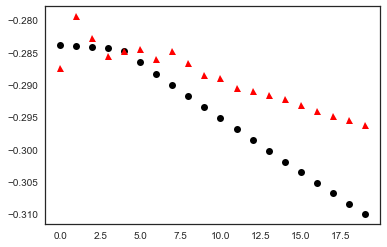

In [15]:
plt.plot(X_new.reshape((batch_size,)), 'ok')
plt.plot(y_pred.reshape((batch_size,)), '^r')

In [16]:
sess.close()